# Variability of the tracer concentration in the Australian-Antarctic Basin


In this notebook, I want to compute a time-series of the ALBW and RSBW fraction in the abyssal Australian-Antarctic Basin (below the 4000 m isobath).

In [ ]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import climtas.nci
from pint import application_registry as ureg
import pint_xarray
import matplotlib.colors as col
from scipy import stats

from palettable.scientific.sequential import * 
from palettable.scientific.diverging import * 

import sys
sys.path.append("/g/data/x77/ps7863/python_scripts")
import helper_functions as helper

In [ ]:
climtas.nci.GadiClient()

In [ ]:
figdir = '/g/data/x77/ps7863/figures/Figures_for_paper/'

In [ ]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

In [ ]:
first_year = '1958'
last_year = '2018'
start_time=first_year+'-01-01'
end_time=last_year+'-12-31'
time_slice = slice(start_time, end_time)

In [ ]:
lat_slice = slice(-78, -50)
lon_slice = slice(-280, -170)


In [46]:
tr_adelie = cc.querying.getvar(iaf_cycle3, 'passive_adelie', session,
                            frequency='1 monthly',
                            attrs={'cell_methods': 'time: mean'},
                            start_time=start_time, end_time=end_time,
                            chunks={'time':12, 'xt_ocean':100, 'yt_ocean':100})

tr_adelie = tr_adelie.sel(time=time_slice).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

tr_ross = cc.querying.getvar(iaf_cycle3, 'passive_ross',
                            session,
                            frequency='1 monthly',
                            attrs={'cell_methods': 'time: mean'},
                            start_time=start_time, end_time=end_time,
                            chunks={'time':12, 'xt_ocean':100, 'yt_ocean':100})

tr_ross = tr_ross.sel(time=time_slice).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/en

In [47]:
bot_mask = tr_ross.where(~np.isfinite(tr_ross.shift({'st_ocean': -1})))
bot_mask = ~np.isnan(bot_mask)
bot_mask

<xarray.DataArray 'passive_ross' (time: 732, st_ocean: 75, yt_ocean: 592,
                                  xt_ocean: 1100)> Size: 36GB
dask.array<invert, shape=(732, 75, 592, 1100), dtype=bool, chunksize=(3, 19, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 9kB -279.9 -279.8 -279.7 ... -170.1 -170.0
  * yt_ocean  (yt_ocean) float64 5kB -77.98 -77.94 -77.9 ... -50.09 -50.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
Attributes:
    long_name:      passive (ross)
    units:          dimensionless
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-11-11
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

In [48]:
bottom_adelie = tr_adelie.where(bot_mask).sum(dim='st_ocean')
bottom_ross = tr_ross.where(bot_mask).sum(dim='st_ocean')

In [49]:
bottom_adelie

<xarray.DataArray 'passive_adelie' (time: 732, yt_ocean: 592, xt_ocean: 1100)> Size: 2GB
dask.array<sum-aggregate, shape=(732, 592, 1100), dtype=float32, chunksize=(3, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 9kB -279.9 -279.8 -279.7 ... -170.1 -170.0
  * yt_ocean  (yt_ocean) float64 5kB -77.98 -77.94 -77.9 ... -50.09 -50.03
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...

Load contour 

In [50]:
fpath = '/g/data/x77/ps7863/data/Isobath_contours_circumpolar_upd/Antarctic_slope_contour_4000m.npz'
data = np.load(fpath)
contour_masked_above = data['contour_masked_above']
xt_ocean = data['xt_ocean']
yt_ocean = data['yt_ocean']

In [41]:
contour_masked_above.shape, xt_ocean.shape, yt_ocean.shape

((650, 3600), (3600,), (649,))

In [51]:
contour_masked_above = xr.DataArray(contour_masked_above[:-1,:], dims=['yt_ocean', 'xt_ocean'], coords=[yt_ocean, xt_ocean])
mask = contour_masked_above == 0
mask

<xarray.DataArray (yt_ocean: 649, xt_ocean: 3600)> Size: 2MB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -51.17 -51.11
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95

In [52]:
mask = contour_masked_above == 0

In [62]:
# Calculate abyssal-average of the bottom tracer concentrations
bottom_adelie_mean = (bottom_adelie*mask).mean(dim={'xt_ocean', 'yt_ocean'}).load()
bottom_ross_mean = (bottom_ross*mask).mean(dim={'xt_ocean', 'yt_ocean'}).load()


KeyboardInterrupt



2024-12-17 10:35:24,914 - distributed.worker.state_machine - ERROR - Unhandled exception in async instruction for <Task finished name='gather_dep(tcp://127.0.0.1:45885, {...})' coro=<Worker.gather_dep() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/worker_state_machine.py:3606> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/worker_state_machine.py", line 3629, in _finish_async_instruction
    stim = task.result()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/worker_state_machine.py", line 3609, in wrapper
    return await func(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/worker.py", line 223, in wrapper
    return await method(self, *args, **kwargs)  # type: ignor

KeyboardInterrupt: 

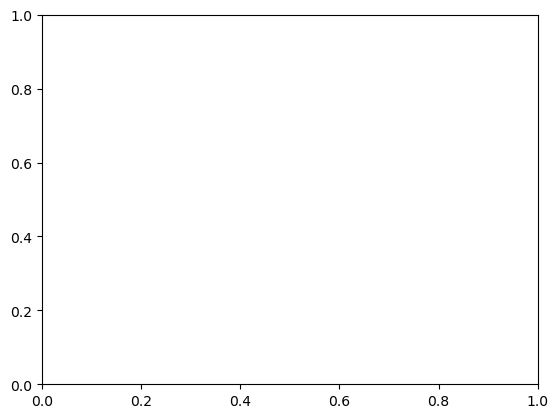

In [61]:
plt.plot(bottom_adelie_mean)
plt.plot(bottom_ross_mean)

In [ ]:
albw_concentration = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/ALBW_concentration_bottom_timeseries_1958-2018.nc')
albw_concentration = albw_concentration['__xarray_dataarray_variable__']
rsbw_concentration = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/RSBW_concentration_bottom_timeseries_1958-2018.nc')
rsbw_concentration = rsbw_concentration['__xarray_dataarray_variable__']

In [68]:
# Calculate mean bottom fractions 

adelie_bottom_fraction = albw_concentration / (albw_concentration + rsbw_concentration)
ross_bottom_fraction = rsbw_concentration / (albw_concentration + rsbw_concentration)

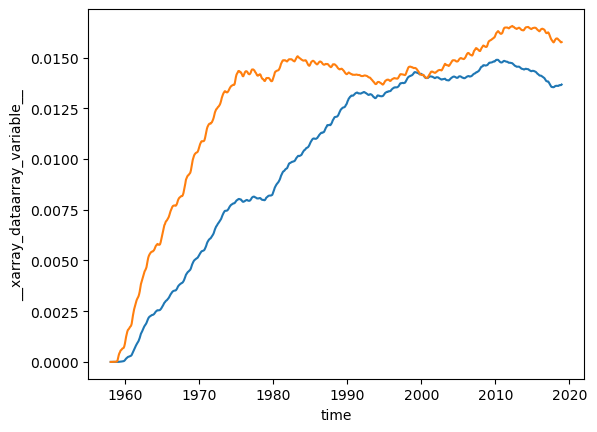

In [73]:
rsbw_concentration.plot()
albw_concentration.plot()

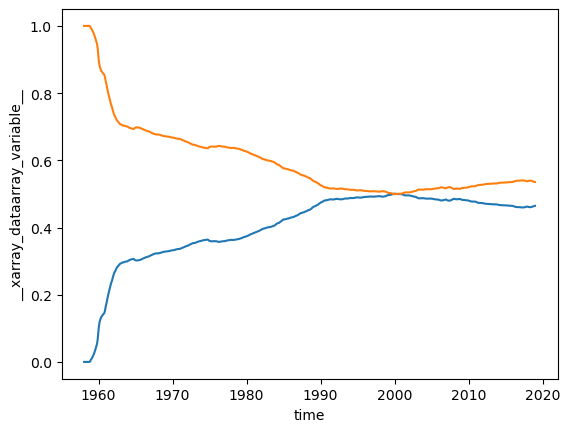

In [71]:
ross_bottom_fraction.plot()
adelie_bottom_fraction.plot()

In [ ]:
rsbw_concentration_climatology = rsbw_concentration.groupby('time.month').mean('time')
albw_concentration_climatology = albw_concentration.groupby('time.month').mean('time')

rsbw_concentration_range = rsbw_concentration_climatology.max() - rsbw_concentration_climatology.min()
albw_concentration_range = albw_concentration_climatology.max() - albw_concentration_climatology.min() 

In [81]:
rsbw_concentration_deseasoned = rsbw_concentration.rolling(time=12, center=True).mean()
albw_concentration_deseasoned = albw_concentration.rolling(time=12, center=True).mean()

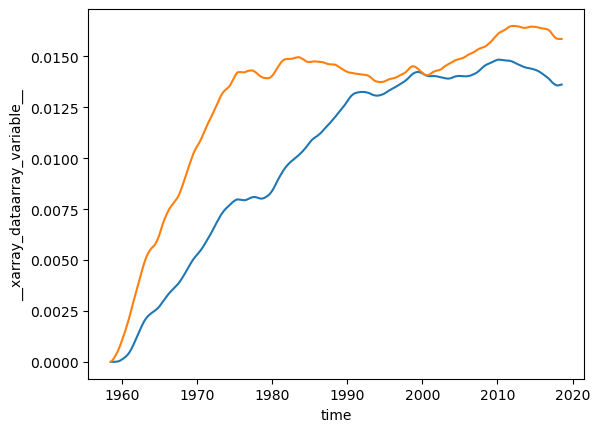

In [82]:
rsbw_concentration_deseasoned.plot()
albw_concentration_deseasoned.plot()

In [83]:
# Calculate mean bottom fractions 

adelie_bottom_fraction_deseasoned = albw_concentration_deseasoned / (albw_concentration_deseasoned + rsbw_concentration_deseasoned)
ross_bottom_fraction_deseasoned = rsbw_concentration_deseasoned / (albw_concentration_deseasoned + rsbw_concentration_deseasoned)

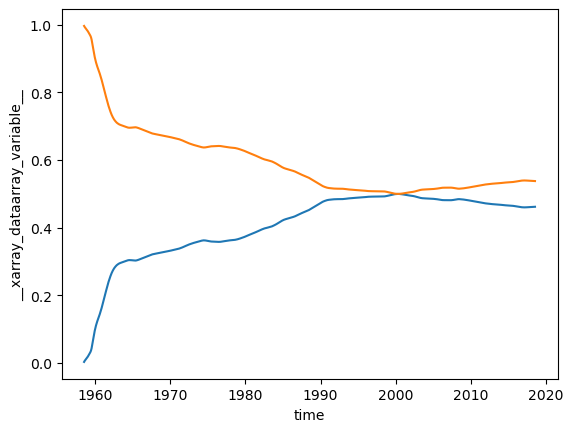

In [84]:
ross_bottom_fraction_deseasoned.plot()
adelie_bottom_fraction_deseasoned.plot()